In [27]:
!pip install xgboost lightgbm catboost --quiet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import joblib
import json
import os

sns.set(style="whitegrid")



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CarPrice_Assignment.csv")
df.head()


In [ ]:
print("Shape:", df.shape)
print("\nInfo:")
df.info()

print("\nDescribe (numeric):")
display(df.describe())

print("\nMissing values per column:")
print(df.isnull().sum())


In [ ]:
# Distribution of price
plt.figure(figsize=(7,4))
sns.histplot(df["price"], kde=True)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.show()

# Log-price distribution (optional)
plt.figure(figsize=(7,4))
sns.histplot(np.log1p(df["price"]), kde=True)
plt.title("Log(Price + 1) Distribution")
plt.xlabel("log(price + 1)")
plt.show()

# Correlation heatmap for some numeric features
num_cols = [
    "price", "enginesize", "horsepower", "curbweight",
    "citympg", "highwaympg", "wheelbase", "carlength", "carwidth"
]

plt.figure(figsize=(10,8))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# Scatter: horsepower vs price
plt.figure(figsize=(6,4))
sns.scatterplot(x="horsepower", y="price", data=df)
plt.title("Horsepower vs Price")
plt.show()

# Scatter: enginesize vs price
plt.figure(figsize=(6,4))
sns.scatterplot(x="enginesize", y="price", data=df)
plt.title("Engine Size vs Price")
plt.show()


In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(x="fueltype", y="price", data=df)
plt.title("Fuel Type vs Price")
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x="carbody", y="price", data=df)
plt.title("Car Body vs Price")
plt.show()

# Extract brand from CarName
df["brand"] = df["CarName"].str.split(" ").str[0].str.lower()

plt.figure(figsize=(10,4))
avg_price_by_brand = df.groupby("brand")["price"].mean().sort_values(ascending=False).head(15)
sns.barplot(x=avg_price_by_brand.index, y=avg_price_by_brand.values)
plt.title("Top 15 Brands by Average Price")
plt.xticks(rotation=60)
plt.show()


In [ ]:
def preprocess_data(df_raw: pd.DataFrame):
    df = df_raw.copy()

    # Extract brand from CarName
    df["brand"] = df["CarName"].str.split(" ").str[0].str.lower()

    # Fix a few common brand name typos
    brand_replacements = {
        "vw": "volkswagen",
        "vokswagen": "volkswagen",
        "porcshe": "porsche",
        "toyouta": "toyota",
        "maxda": "mazda",
        "nissan": "nissan"  # ensure lowercase to match .str.lower()
    }
    df["brand"] = df["brand"].replace(brand_replacements)

    # Drop ID-like columns and raw CarName (we now use brand instead)
    cols_to_drop = []
    if "car_ID" in df.columns:
        cols_to_drop.append("car_ID")
    cols_to_drop += ["CarName"]

    df = df.drop(columns=cols_to_drop)

    # Drop rows with missing target
    df = df.dropna(subset=["price"])

    # Separate target
    y = df["price"]
    X = df.drop("price", axis=1)

    # One-hot encode categorical features
    cat_cols = X.select_dtypes(include=["object"]).columns
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

    # Train–test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Scale features (good for linear models, ok for trees too)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, scaler, X.columns.tolist()


X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, scaler, feature_cols = preprocess_data(df)

len(feature_cols), X_train.shape, X_train_scaled.shape


In [ ]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test, scaled=True):
    if scaled:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds) ** 0.5
    r2 = r2_score(y_test, preds)

    print(f"{name:20s} | MAE: {mae:8.2f} | RMSE: {rmse:8.2f} | R2: {r2:6.3f}")
    return {"model": model, "MAE": mae, "RMSE": rmse, "R2": r2}


In [ ]:
results = {}
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=4,
        subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric="rmse"
    ),
    "LightGBM": LGBMRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(
        depth=6, learning_rate=0.05, iterations=300, verbose=0, random_state=42
    )
}

for name, model in models.items():
    # use scaled features for all (ok, even if trees don't need it)
    res = evaluate_model(name, model, X_train_scaled, X_test_scaled, y_train, y_test, scaled=True)
    results[name] = res

results


In [28]:
def tune_random_forest(X_train, y_train):
    rf = RandomForestRegressor(random_state=42)
    param_dist = {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 4, 6, 8, 10],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    }
    rsearch = RandomizedSearchCV(
        rf, param_dist, n_iter=10, scoring="neg_root_mean_squared_error",
        cv=3, random_state=42, n_jobs=-1, verbose=1
    )
    rsearch.fit(X_train, y_train)
    return rsearch.best_estimator_


def tune_gradient_boosting(X_train, y_train):
    gb = GradientBoostingRegressor(random_state=42)
    param_dist = {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [2, 3, 4]
    }
    rsearch = RandomizedSearchCV(
        gb, param_dist, n_iter=10, scoring="neg_root_mean_squared_error",
        cv=3, random_state=42, n_jobs=-1, verbose=1
    )
    rsearch.fit(X_train, y_train)
    return rsearch.best_estimator_


print("Tuning Random Forest...")
best_rf = tune_random_forest(X_train_scaled, y_train)

print("Tuning Gradient Boosting...")
best_gb = tune_gradient_boosting(X_train_scaled, y_train)

print("Evaluating tuned models:")
results["RandomForest_Tuned"] = evaluate_model(
    "RandomForest_Tuned", best_rf, X_train_scaled, X_test_scaled, y_train, y_test
)
results["GradientBoosting_Tuned"] = evaluate_model(
    "GradientBoosting_Tuned", best_gb, X_train_scaled, X_test_scaled, y_train, y_test
)


Tuning Random Forest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Tuning Gradient Boosting...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Evaluating tuned models:
RandomForest_Tuned   | MAE:  1520.15 | RMSE:  2131.92 | R2:  0.942
GradientBoosting_Tuned | MAE:  1716.89 | RMSE:  2318.98 | R2:  0.932


,Model,MAE,RMSE,R2
4,RandomForest,1287.565073,1821.998015,0.957949
9,RandomForest_Tuned,1520.147800,2131.915272,0.942427
8,CatBoost,1438.330259,2220.239078,0.937558
6,XGBoost,1599.282774,2313.499231,0.932202
10,GradientBoosting_Tuned,1716.888353,2318.984822,0.931880
5,GradientBoosting,1696.478161,2422.980245,0.925633
0,LinearRegression,1765.455148,2670.563696,0.909659
1,Ridge,1821.983976,2687.301707,0.908523
3,DecisionTree,1863.174805,2766.941411,0.903020
2,Lasso,1809.047426,2791.955830,0.901259


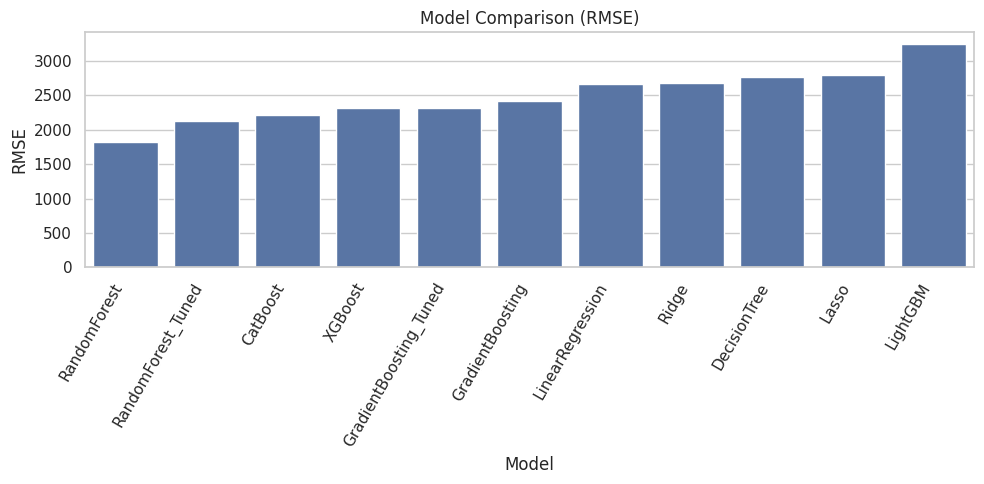

Best model: RandomForest


In [15]:
results_df = pd.DataFrame([
    {"Model": name, "MAE": r["MAE"], "RMSE": r["RMSE"], "R2": r["R2"]}
    for name, r in results.items()
])

results_df = results_df.sort_values(by="RMSE")
display(results_df)

plt.figure(figsize=(10,5))
sns.barplot(data=results_df, x="Model", y="RMSE")
plt.xticks(rotation=60, ha="right")
plt.title("Model Comparison (RMSE)")
plt.tight_layout()
plt.show()

best_model_name = results_df.iloc[0]["Model"]
print("Best model:", best_model_name)


In [29]:
best_model = results[best_model_name]["model"]

# Save into a local folder so you can use it in your API / Docker
MODELS_DIR = "car_price_models"
os.makedirs(MODELS_DIR, exist_ok=True)

model_path = os.path.join(MODELS_DIR, "best_model.pkl")
scaler_path = os.path.join(MODELS_DIR, "scaler.pkl")
features_path = os.path.join(MODELS_DIR, "feature_columns.json")

joblib.dump(best_model, model_path)
joblib.dump(scaler, scaler_path)
with open(features_path, "w") as f:
    json.dump(feature_cols, f)

print("Saved model to:", model_path)
print("Saved scaler to:", scaler_path)
print("Saved feature columns to:", features_path)


Saved model to: car_price_models/best_model.pkl
Saved scaler to: car_price_models/scaler.pkl
Saved feature columns to: car_price_models/feature_columns.json


In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 👇 use X_train_scaled / X_test_scaled if you have them,
# otherwise use X_train / X_test directly
Xtr = X_train_scaled   # or X_train
Xte = X_test_scaled    # or X_test

# 1. Build a simple regression model
model = Sequential()
model.add(Dense(128, activation="relu", input_shape=(Xtr.shape[1],)))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1))  # one value: predicted price

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# 2. Train
history = model.fit(
    Xtr, y_train,
    validation_data=(Xte, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# 3. Save as model.h5
model.save("model.h5")
print("✔ Saved Keras model as model.h5")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 263514432.0000 - mae: 13935.0156 - val_loss: 260883488.0000 - val_mae: 13488.6064
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 238281104.0000 - mae: 13226.6602 - val_loss: 260838720.0000 - val_mae: 13487.1475
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 205312640.0000 - mae: 12679.6152 - val_loss: 260776032.0000 - val_mae: 13485.1523
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 222962112.0000 - mae: 12797.4902 - val_loss: 260678656.0000 - val_mae: 13482.2148
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 247292480.0000 - mae: 13631.3809 - val_loss: 260536944.0000 - val_mae: 13478.0430
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 230734720.0000 - mae: 12975.9131 - val_loss: 260331776.0000 - val_mae: 13472.1611
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 234025568.0000 - mae: 13164.7012 - val_loss: 260023776.0000 - val_mae: 13463.6201
Epoch 8/50
6/6 ━━━━━━━━━━━━

✔ Saved Keras model as model.h5
